# Quantum Algorithm for Imaginary Time Evolution of H = X Single Qubit System

In [10]:
import qiskit
import numpy as np
import cmath
import matplotlib.pyplot as plt
import scipy.special as sp
from scipy import signal
from qiskit import QuantumCircuit, assemble, Aer, transpile, execute
from qiskit.visualization import plot_histogram
from math import sqrt, pi, exp
from qiskit.providers.fake_provider import FakeHanoi # Get a fake backend from the fake provider
import datetime

sim = Aer.get_backend('aer_simulator')

#Definition of the fake backend
fakebackend = FakeHanoi()



#Control-Hadamard gate
def ch(cq, q, qc):  
    qc.ry(pi / 4, q)
    qc.cx(cq, q)
    qc.ry(-pi / 4, q)


#Prepares the |G_bar> state: normalized list of the square root of the Chebyshev expansion's coefficients
def Gb_state(time, nmax):   
    V = []
    V.append(np.sqrt((sp.jv(0, complex(0, time))).real))
    for i in range(nmax):
        V.append(np.sqrt((2*(complex(0, 1)**(i + 1))*sp.jv(i + 1, complex(0, - time))).real))
    V = np.array(V)
    V = V / np.linalg.norm(V, 2)
    V = list(V)
    return V
    
    
#Recursive definition of a multi-controlled Toffoli gate: C^nX
#q_control = list of control qubits
#q_target = list with the unique target qubit
#q_ancilla = list of the ancilla qubits
#For n control qubits, there is n - 2 ancilla qubits and 1 target qubit
def control_n_X(q_control, q_ancilla, q_target, qc): 
    if len(q_control) == 2:
        qc.ccx(q_control[0], q_control[1], q_target[0])
    else:

        q_control_1 = q_ancilla[-1]
        q_control_2 = q_control[-1]


        q_control = q_control[0:len(q_control)-1]
        q_ancilla = q_ancilla[0:len(q_ancilla)-1]

        control_n_X(q_control, q_ancilla, [q_control_1], qc)  
        qc.ccx(q_control_1, q_control_2, q_target)
        control_n_X(q_control, q_ancilla, [q_control_1], qc)  
            

            
#Definition of the circuit for the experiment
def circuit_toy_model(time, system_state):


    qc = QuantumCircuit(5, 4)
    
    q_s = 0  #system qubit
    q_a = 1  #ancilla-a qubit for unitary encoding of Hamiltonian
    q_ab1 = 2  #ancilla-ab qubits for unitary encoding of Chebyshev expansion
    q_ab2 = 3
    q_A = 4  #ancilla-A qubits for implementation of C^3X gates

    
   #Initialize system's state
    qc.initialize(system_state, q_s) 

    #Initialize |G>_a = |1>_a  
    qc.x(q_a) 

    #Initialize |Gb>_ab 
    Cheb_state = Gb_state(time, 2)
    Cheb_state.append(0.0)  #We add a zero because the state of two qubits has 4 coefficients
    U_Gb_state = qiskit.extensions.Initialize(Cheb_state)  #Gate the prepares |Gb>_ab  
    U_Gb_state.label = "U_Gb_state"
    qc.append(U_Gb_state, [q_ab2, q_ab1])  

    
    
    
    #control-(-W_X), applied if (q_ab1, q_ab2) = (0, 1)
    qc.x(q_ab1)
    
    control_n_X([q_a, q_ab1, q_ab2], [q_A], [q_s], qc)
    qc.h(q_a)
    qc.ccx(q_ab1, q_ab2, q_a)
    qc.h(q_a)
    
    qc.x(q_ab1)
    
    
    
    #control-(-W_X)^2, applied if (q_ab1, q_ab2) = (1, 0)
    qc.x(q_ab2)
    
    control_n_X([q_a, q_ab1, q_ab2], [q_A], [q_s], qc)
    qc.h(q_a)
    qc.ccx(q_ab1, q_ab2, q_a)
    qc.h(q_a)
    
    control_n_X([q_a, q_ab1, q_ab2], [q_A], [q_s], qc)
    qc.h(q_a)
    qc.ccx(q_ab1, q_ab2, q_a)
    qc.h(q_a)
    
    qc.x(q_ab2)
    

    #Uncompute |G>_a 
    qc.x(q_a)

    #Uncompute |Gb>_ab 
    U_Gb_state_inverse = U_Gb_state.gates_to_uncompute()         
    qc.append(U_Gb_state_inverse, [q_ab2, q_ab1])
    
    
    #Measurement of energy transfered to q_A
    qc.h(q_A)
    qc.cx(q_A, q_s)
    qc.h(q_A)


    #Measurement of all ancilla qubits
    qc.measure([q_A, q_a, q_ab1, q_ab2], [0, 1, 2, 3])
    
    return qc

In [11]:
circuit_toy_model(time = 2.05, system_state = [1, 0]).draw()

┌─────────────────┐                      ┌───┐               »
q_0: ───────────┤ Initialize(1,0) ├──────────────────────┤ X ├───────────────»
                └──────┬───┬──────┘                      └─┬─┘     ┌───┐┌───┐»
q_1: ──────────────────┤ X ├──────────────────────────■────┼────■──┤ H ├┤ X ├»
     ┌─────────────────┴───┴──────────────────┐┌───┐  │    │    │  └───┘└─┬─┘»
q_2: ┤1                                       ├┤ X ├──■────┼────■─────────■──»
     │  U_Gb_state(0.57407,0.68206,0.45304,0) │└───┘  │    │    │         │  »
q_3: ┤0                                       ├───────┼────■────┼─────────■──»
     └────────────────────────────────────────┘     ┌─┴─┐  │  ┌─┴─┐          »
q_4: ───────────────────────────────────────────────┤ X ├──■──┤ X ├──────────»
                                                    └───┘     └───┘          »
c: 4/════════════════════════════════════════════════════════════════════════»
                                                                             »
«               ┌───┐                         ┌───┐               ┌───┐     »
«q_0: ──────────┤ X ├─────────────────────────┤ X ├───────────────┤ X ├─────»
«     ┌───┐     └─┬─┘     ┌───┐┌───┐┌───┐     └─┬─┘     ┌───┐┌───┐└─┬─┘┌───┐»
«q_1: ┤ H ├──■────┼────■──┤ H ├┤ X ├┤ H ├──■────┼────■──┤ H ├┤ X ├──┼──┤ H ├»
«     ├───┤  │    │    │  └───┘└─┬─┘└───┘  │    │    │  └───┘└─┬─┘  │  └───┘»
«q_2: ┤ X ├──■────┼────■─────────■─────────■────┼────■─────────■────┼───────»
«     ├───┤  │    │    │         │         │    │    │         │    │  ┌───┐»
«q_3: ┤ X ├──┼────■────┼─────────■─────────┼────■────┼─────────■────┼──┤ X ├»
«     └───┘┌─┴─┐  │  ┌─┴─┐               ┌─┴─┐  │  ┌─┴─┐┌───┐       │  ├───┤»
«q_4: ─────┤ X ├──■──┤ X ├───────────────┤ X ├──■──┤ X ├┤ H ├───────■──┤ H ├»
«          └───┘     └───┘               └───┘     └───┘└───┘          └───┘»
«c: 4/══════════════════════════════════════════════════════════════════════»
«                                                                           »
«                               
«q_0: ──────────────────────────
«           ┌───┐      ┌─┐      
«q_1: ──────┤ X ├──────┤M├──────
«     ┌─────┴───┴─────┐└╥┘┌─┐   
«q_2: ┤1              ├─╫─┤M├───
«     │  disentangler │ ║ └╥┘┌─┐
«q_3: ┤0              ├─╫──╫─┤M├
«     └──────┬─┬──────┘ ║  ║ └╥┘
«q_4: ───────┤M├────────╫──╫──╫─
«            └╥┘        ║  ║  ║ 
«c: 4/════════╩═════════╩══╩══╩═
«             0         1  2  3

# Ideal time evolution of the distance between system's state and ground state

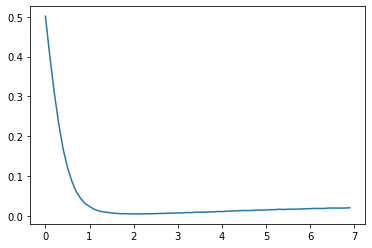

In [2]:
time_steps = 70
dt = 0.1
n_run = 20
n_shots = 20000


#Initial system's state is |0>
initial_state_sys = [1, 0]


#Loop that creates a list of all the transpiled circuits for the experiment
transpiled_circuits = []
for k in range(time_steps):
    for l in range(n_run):
        transpiled_circuits.append(transpile(circuit_toy_model(dt*k, initial_state_sys), sim))
        

#We run the algorithm using the ideal simulator
job = sim.run(transpiled_circuits, shots = n_shots)
counts = job.result().get_counts()


#Loop that creates a list of the average probabilities over time
proba0_list = []

for k in range(time_steps):
   
    #List that contains the number of '0000' counts for each fixed time run
    counts0_list_fixed_time = []
    #List that contains the number of '0001' counts for each fixed time run
    counts1_list_fixed_time = []
    
    
    for l in range(n_run):

        #indicator0 = 1 if '0000' is in counts and = 0 otherwise
        indicator0 = sum(['0000' == list(counts[k*n_run + l].keys())[m] for m in range(len(counts[k*n_run + l]))])
        
        if indicator0 == 0:
            counts0 = 0

        else:
            counts0 = counts[k*n_run + l]['0000']

        #indicator1 = 1 if '0001' is in counts and = 0 otherwise
        indicator1 = sum(['0001' == list(counts[k*n_run + l].keys())[m] for m in range(len(counts[k*n_run + l]))])
        
        if indicator1 == 0:
            counts1 = 0

        else:
            counts1 = counts[k*n_run + l]['0001']
            
        counts0_list_fixed_time.append(counts0)
        counts1_list_fixed_time.append(counts1)
        
    
    #Average '0000' counts over the n_run runs
    counts0_average_fixed_time = sum(counts0_list_fixed_time) / len(counts0_list_fixed_time) 
    #Average '0001' counts over the n_run runs
    counts1_average_fixed_time = sum(counts1_list_fixed_time) / len(counts1_list_fixed_time)  

    
    #Construct a probability for '0000' state measurement with these average counts, proba is added to proba0_list
    proba0_list.append(counts0_average_fixed_time/(counts0_average_fixed_time + counts1_average_fixed_time))  


time_list = [dt*k for k in range(time_steps)]


proba0_over_time = plt.plot(time_list, proba0_list)   
plt.show(proba0_over_time)

# Time evolution of the distance with simulated backend

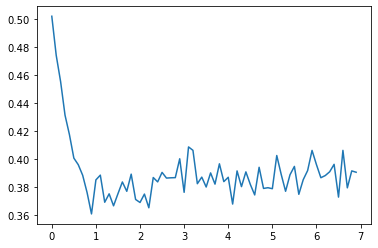

In [3]:
time_steps = 70
dt = 0.1
n_run = 20
n_shots = 20000

#Initial system's state is |0>
initial_state_sys = [1, 0]


#Loop that creates a list of all the transpiled circuits for the experiment
transpiled_circuits = []
for k in range(time_steps):
    for l in range(n_run):
        transpiled_circuits.append(transpile(circuit_toy_model(dt*k, initial_state_sys), fakebackend))

        
#We run the algorithm using the fakebackend
job = fakebackend.run(transpiled_circuits, shots = n_shots)
counts = job.result().get_counts()


#Loop that creates a list of the average probabilities over time
proba0_list = []

for k in range(time_steps):
   
    #List that contains the number of '0000' counts for each fixed time run
    counts0_list_fixed_time = []
    #List that contains the number of '0001' counts for each fixed time run
    counts1_list_fixed_time = []
    
    
    for l in range(n_run):
        
        #indicator0 = 1 if '0000' is in counts and = 0 otherwise
        indicator0 = sum(['0000' == list(counts[k*n_run + l].keys())[m] for m in range(len(counts[k*n_run + l]))])

        if indicator0 == 0:
            counts0 = 0

        else:
            counts0 = counts[k*n_run + l]['0000']

        #indicator1 = 1 if '0001' is in counts and = 0 otherwise
        indicator1 = sum(['0001' == list(counts[k*n_run + l].keys())[m] for m in range(len(counts[k*n_run + l]))])
        
        if indicator1 == 0:
            counts1 = 0

        else:
            counts1 = counts[k*n_run + l]['0001']
            
        
        counts0_list_fixed_time.append(counts0)
        counts1_list_fixed_time.append(counts1)
        
    #Average '0000' counts over the n_run runs
    counts0_average_fixed_time = sum(counts0_list_fixed_time) / len(counts0_list_fixed_time) 
    #Average '0001' counts over the n_run runs
    counts1_average_fixed_time = sum(counts1_list_fixed_time) / len(counts1_list_fixed_time)  

    
    #Construct a probability for '0000' state measurement with these average counts, proba is added to proba0_list
    proba0_list.append(counts0_average_fixed_time/(counts0_average_fixed_time + counts1_average_fixed_time))  


time_list = [dt*k for k in range(time_steps)]


proba0_over_time = plt.plot(time_list, proba0_list)   
plt.show(proba0_over_time)

# Characteristics of the fake backend

In [4]:
config = fakebackend.configuration()
props = fakebackend.properties()

# Basic Features
print("This backend is called {0}, and is on version {1}. It has {2} qubit{3}. It "
      "{4} OpenPulse programs. The basis gates supported on this device are {5}. The coupling map is {6}"
      "".format(config.backend_name,
                config.backend_version,
                config.n_qubits,
                '' if config.n_qubits == 1 else 's',
                'supports' if config.open_pulse else 'does not support',
                config.basis_gates, config.coupling_map))

def describe_qubit(qubit, properties):
    """Print a string describing some of reported properties of the given qubit."""

    # Conversion factors from standard SI units
    us = 1e6
    ns = 1e9
    GHz = 1e-9

    print("Qubit {0} has a \n"
          "  - T1 time of {1} microseconds\n"
          "  - T2 time of {2} microseconds\n"
          "  - U2 gate error of {3}\n"
          "  - U2 gate duration of {4} nanoseconds\n"
          "  - resonant frequency of {5} GHz".format(
              qubit,
              properties.t1(qubit) * us,
              properties.t2(qubit) * us,
              properties.gate_error('sx', qubit),
              properties.gate_length('sx', qubit) * ns,
              properties.frequency(qubit) * GHz))

for i in range(27):
    describe_qubit(i, props)

This backend is called fake_hanoi, and is on version 1.0.18. It has 27 qubits. It supports OpenPulse programs. The basis gates supported on this device are ['id', 'rz', 'sx', 'x', 'cx', 'reset']. The coupling map is [[0, 1], [1, 0], [1, 2], [1, 4], [2, 1], [2, 3], [3, 2], [3, 5], [4, 1], [4, 7], [5, 3], [5, 8], [6, 7], [7, 4], [7, 6], [7, 10], [8, 5], [8, 9], [8, 11], [9, 8], [10, 7], [10, 12], [11, 8], [11, 14], [12, 10], [12, 13], [12, 15], [13, 12], [13, 14], [14, 11], [14, 13], [14, 16], [15, 12], [15, 18], [16, 14], [16, 19], [17, 18], [18, 15], [18, 17], [18, 21], [19, 16], [19, 20], [19, 22], [20, 19], [21, 18], [21, 23], [22, 19], [22, 25], [23, 21], [23, 24], [24, 23], [24, 25], [25, 22], [25, 24], [25, 26], [26, 25]]
Qubit 0 has a 
  - T1 time of 162.29562357444243 microseconds
  - T2 time of 171.74648699183206 microseconds
  - U2 gate error of 0.00013790682762652163
  - U2 gate duration of 21.333333333333332 nanoseconds
  - resonant frequency of 5.035257503599211 GHz
Qubit 1

In [5]:
## Gates error rates ##

for gate_i in props.gates:
    print("{} gate on qubits {} error rate is {}{}".format(gate_i.name, gate_i.qubits, gate_i.parameters[0].value, gate_i.parameters[0].unit))

id0 gate on qubits [0] error rate is 0.00013790682762652163
id1 gate on qubits [1] error rate is 0.00015157374263301623
id2 gate on qubits [2] error rate is 0.00016393621420542743
id3 gate on qubits [3] error rate is 0.00014780011919478462
id4 gate on qubits [4] error rate is 0.00015781468511476068
id5 gate on qubits [5] error rate is 0.00027756496231637746
id6 gate on qubits [6] error rate is 0.0001885422462640474
id7 gate on qubits [7] error rate is 0.00011454203030407228
id8 gate on qubits [8] error rate is 0.00020613384927090794
id9 gate on qubits [9] error rate is 0.00022556897197118007
id10 gate on qubits [10] error rate is 0.0001561651483167148
id11 gate on qubits [11] error rate is 0.00010057601299122221
id12 gate on qubits [12] error rate is 0.00012071151678724592
id13 gate on qubits [13] error rate is 0.00012657380561906245
id14 gate on qubits [14] error rate is 0.00020637437176042607
id15 gate on qubits [15] error rate is 0.0004358587992589599
id16 gate on qubits [16] error 